# Necessary Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
from sklearn.compose import ColumnTransformer

# New Section

In [41]:
data = pd.read_csv('../data.csv')
data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [42]:
# We can fill NaN values for number of children with 0 (only 4 NaN values)
data['children'] = data['children'].fillna(0)

In [43]:
data['arrival_date_month'].replace(
                                  ['July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June'],
                                  [7,8,9,10,11,12,1,2,3,4,5,6],
                                  inplace=True
                              )

data.rename(columns={'arrival_date_year': 'year', 
                  'arrival_date_month': 'month',
                  'arrival_date_day_of_month': 'day'
                  }, 
               inplace=True
              )

data.insert(3,'arrival_date',pd.to_datetime(data[['year', 'month', 'day']]))

In [44]:
# Removing country column for now or we can use target encoding
data = data.drop(['country'], axis=1)

# Removing agent and company columns since market_segment gives same information
data = data.drop(['agent','company'], axis=1)

# Removing all columns relating to arrival date except week number and year for now
data = data.drop(['month','day'], axis=1)

In [45]:
# We can combine reserved_room_type and assigned_room_type columns into one that has boolean values for whether reserved and assigned matched
# 0 -> Reserved and assigned room types matched
# 1 -> Reserved and assigned room types didn't match
data['reserved_assigned_match'] = np.where(data['reserved_room_type'] == data['assigned_room_type'], 0, 1)
data = data.drop(['reserved_room_type','assigned_room_type'], axis=1)

In [46]:
# We can change the values in the meal types column. 0, 0.33, 0.67, 1 since the meal types are incremental
data['meal'].replace(['Undefined', 'SC', 'BB', 'HB', 'FB'], [0, 0, 0.33, 0.67, 1], inplace=True)

In [47]:
# We can remove the distribution channels column as market_segment column gives us same information with more granularity
data = data.drop(['distribution_channel'], axis=1)

In [48]:
# data.corr()['is_canceled']

In [49]:
#Remove records where adults, babies, children, stays_in_weekend_nights, stays_in_week_nights, is_canceled values 0,
data.drop(
     data[(data['adults']==0) &
        (data['children']==0) &
        (data['babies']==0) &
        (data['stays_in_weekend_nights']==0) & 
        (data['stays_in_week_nights']==0) &
        (data['is_canceled']==0)].index,
     inplace=True
     )

In [50]:
#Remove records with adr, is_canceled 0, whose market segment is neither Complementary, Corporate nor Aviation
data.drop(data[
    (data["adr"]==0) &  
    (data["is_canceled"]==0)  &
    (data["market_segment"] != "Complementary") &
    (data["market_segment"] != "Corporate") &
    (data["market_segment"] != "Aviation") 
  ].index, 
  inplace = True
  )

In [51]:
#Remove records with stays_in_weekend_nights, stays_in_week_nights 0, arrival and reservation status date are same, reservation status not Check Out
data.drop(data[
    (data["stays_in_week_nights"]==0) &
    (data["stays_in_weekend_nights"]==0) &
    (data["arrival_date"] == data["reservation_status_date"]) &
    (data["reservation_status"]!="Check-Out")
  ].index,
  inplace=True
)

In [52]:
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'],
                                            format = '%Y-%m-%d'
                                            )
data['cancellation_days'] = data['arrival_date'] - data['reservation_status_date']
data['cancellation_days'] = data['cancellation_days'].dt.days
data.head(10)

,hotel,is_canceled,lead_time,arrival_date,year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reserved_assigned_match,cancellation_days
2,Resort Hotel,0,7,2015-07-01,2015,27,0,1,1,0.0,...,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,-1
3,Resort Hotel,0,13,2015-07-01,2015,27,0,1,1,0.0,...,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,0,-1
4,Resort Hotel,0,14,2015-07-01,2015,27,0,2,2,0.0,...,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,0,-2
5,Resort Hotel,0,14,2015-07-01,2015,27,0,2,2,0.0,...,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,0,-2
6,Resort Hotel,0,0,2015-07-01,2015,27,0,2,2,0.0,...,No Deposit,0,Transient,107.0,0,0,Check-Out,2015-07-03,0,-2
7,Resort Hotel,0,9,2015-07-01,2015,27,0,2,2,0.0,...,No Deposit,0,Transient,103.0,0,1,Check-Out,2015-07-03,0,-2
8,Resort Hotel,1,85,2015-07-01,2015,27,0,3,2,0.0,...,No Deposit,0,Transient,82.0,0,1,Canceled,2015-05-06,0,56
9,Resort Hotel,1,75,2015-07-01,2015,27,0,3,2,0.0,...,No Deposit,0,Transient,105.5,0,0,Canceled,2015-04-22,0,70
10,Resort Hotel,1,23,2015-07-01,2015,27,0,4,2,0.0,...,No Deposit,0,Transient,123.0,0,0,Canceled,2015-06-23,0,8
11,Resort Hotel,0,35,2015-07-01,2015,27,0,4,2,0.0,...,No Deposit,0,Transient,145.0,0,0,Check-Out,2015-07-05,0,-4


In [53]:
data.shape
# Reservation Status can be ignored since it is being predicted     -> classification
# Reservation Status can be ignored since we will only be training  -> regression
# on those points where the booking has been cancelled
regression_data = data.copy()
data = data.drop(['reservation_status','reservation_status_date','arrival_date'], axis=1)

In [71]:
data = data.drop(['year','booking_changes','customer_type'], axis=1)

In [72]:
X = data.drop('is_canceled', axis='columns')
y = data.is_canceled
# X = X[:1000]
# y = y[:1000]

## SVM Model

In [73]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [74]:
def get_LR_classifier(features, solver, penalty, c_val):
    # Deposit Type, Customer Type, Hotel and Market Segment will be one hot encoded
    categorical_features = list(set(features) & set([
        'deposit_type',
        'customer_type',
        'hotel',
        'market_segment',
    ]))
    numerical_features = list(set(features) - set(categorical_features))

    columnTransformer = ColumnTransformer(
        transformers = [
            ('categorial', OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ('numerical', StandardScaler(), numerical_features)
        ]
    )

    classifier = make_pipeline(
        columnTransformer,
        LogisticRegression(max_iter=10000, solver=solver, penalty=penalty, C=c_val)
    )
    
    return classifier

def get_SVM_classifier(features):
    # Deposit Type, Customer Type, Hotel and Market Segment will be one hot encoded
    categorical_features = list(set(features) & set([
        'deposit_type',
        'customer_type',
        'hotel',
        'market_segment',
    ]))
    numerical_features = list(set(features) - set(categorical_features))

    columnTransformer = ColumnTransformer(
        transformers = [
            ('categorial', OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ('numerical', StandardScaler(), numerical_features)
        ]
    )

    classifier = make_pipeline(
        columnTransformer,
        svm.SVC()
    )
    
    return classifier

In [75]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [76]:
from itertools import combinations
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy.typing import ArrayLike
from typing import List

In [77]:
print("features: ", X.columns)

features:  Index(['hotel', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'deposit_type', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reserved_assigned_match', 'cancellation_days'],
      dtype='object')


[0.8412152640775604, 0.8946508088608308, 0.9343047178851248, 0.9652218026041373, 0.9819908686094357, 0.9916577419536666, 0.9997745335663153, 0.9993799673073671, 0.9993799673073671]
[0.8412152640775604, 0.8946508088608308, 0.9343047178851248, 0.9652218026041373, 0.9819908686094357, 0.9916577419536666, 0.9997745335663153, 0.9993799673073671, 0.9994081506115777]
[0.8498111718617891, 0.8939462262555662, 0.9335155853672285, 0.9641508370441351, 0.9813426526125923, 0.9914886421284032, 0.9997463502621047, 0.9993799673073671, 0.9993799673073671]


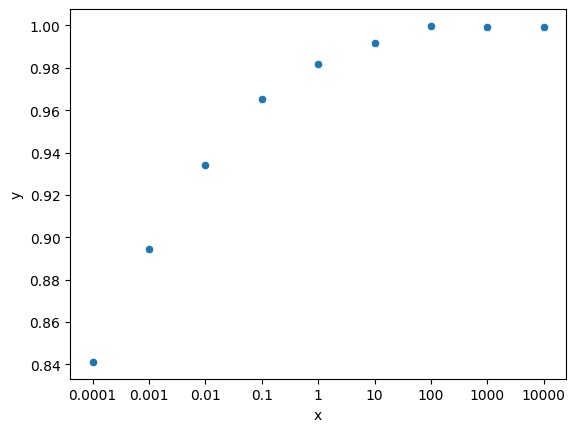

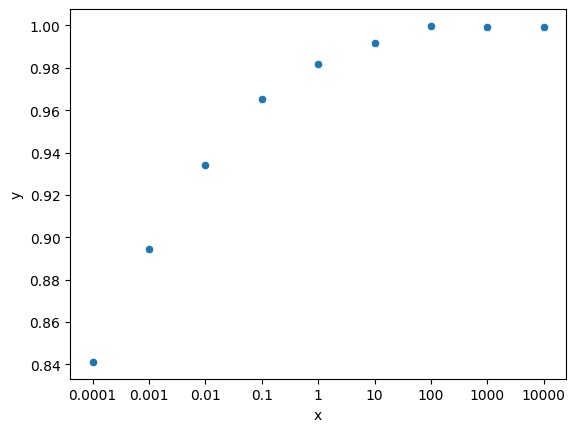

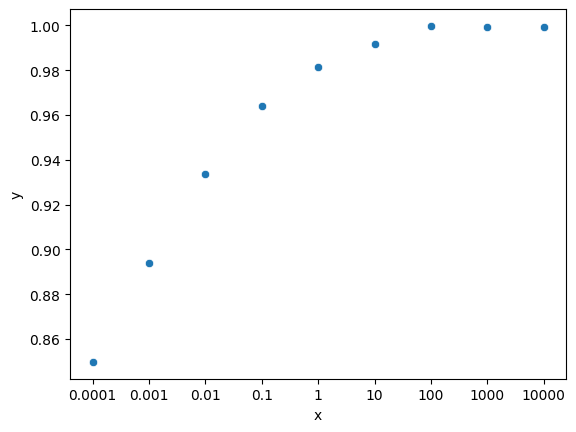

In [78]:
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalties = ['l2']
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
list_string = list(map(str, c_values))
# data = {'x':np.asarray(list_string),'y':np.asarray(c_values)}
# data = pd.DataFrame(data)
# sns.scatterplot(data=data, x='x', y='y')


# # define grid search
# grid = dict(solver=solvers,penalty=penalties,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=classifier, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X, y)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

for solver in solvers:
    for penalty in penalties:
        scores = []
        for c_val in c_values:
            classifier = get_LR_classifier(features, solver, penalty, c_val)
            classifier.fit(X=X_train, y=y_train)
            scores.append(classifier.score(X_test,y_test))
        plot_data = {'x':np.asarray(list_string),'y':np.asarray(scores)}
        plot_data = pd.DataFrame(plot_data)
        plt.figure()
        sns.scatterplot(data=plot_data, x='x', y='y')
        print(scores)

# classifier = get_SVM_classifier(features)
# classifier.fit(X=X_train, y=y_train)
# print("SVM: ", classifier.score(X_test,y_test))

# classifier.fit(X=X_train, y=y_train)
# predictions = classifier.predict(X_test)
# y_test = y_test.to_numpy()
# score = 0
# for i,prediction in enumerate(predictions):
#     if(prediction == y_test[i]):
#         score += 1
# print("Score: ",score/(y_test.size))
#print(cross_val_score(classifier, X, y, cv=10))

In [ ]:
kernels = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


do grid search for SVM
check for overfitting of both models

In [29]:
from itertools import combinations
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy.typing import ArrayLike
from sklearn.model_selection import KFold
from typing import List

In [31]:
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

regressor = get_LR_classifier(features, 'liblinear', 'l2', 10000)
regressor.fit(X=X_train, y=y_train)
print("EQN: ", regressor[1].coef_)
print("Score: ", regressor.score(X_test, y_test))
print(cross_val_score(estimator=get_LR_classifier(features, 'liblinear', 'l2', 10000), X=X, y=y, cv=kfold))

EQN:  [[ 3.41083726e+01  3.46137712e+01  3.41991822e+01  3.41931004e+01
   4.45440266e+01  4.71343853e+01  4.54360145e+01  1.69253529e+01
   1.77594295e+01  1.69858406e+01  1.90002634e+01  1.92039024e+01
   1.81590403e+01  1.84476302e+01  1.06329670e+01  6.88092616e+01
   6.83051648e+01 -2.31115531e-01  1.09666428e-01  5.43818058e-02
  -6.01662913e-02  6.27362068e-02 -1.58859155e-01 -3.15836993e-01
  -4.09663745e-01  1.54909809e-02 -1.32922396e-01  1.27060782e-01
  -3.63349944e+01  2.41849139e-01  1.43418071e-01  7.25432126e+02
   5.33296215e-01 -6.11512051e-01 -1.52409030e-01 -9.16054793e-02]]
Score:  0.9994081589515958
[0.99932361 0.99945043 0.99923903 0.99932358 0.99945041]


In [32]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [33]:
class Solution:
    features: List[int]
    mse: float

    def __init__(self, y: ArrayLike):
        self.features = list()
        self.mse = mean_squared_error(y, [y.mean()]*len(y))

    def update(self, features: List[int], mse: float) -> bool:
        if(mse < self.mse):
            print(', '.join(str(x) for x in features))
            print(f"\tNew Error: {mse:.3f} better than {self.mse:.3f}")
            self.features = features
            self.mse = mse
            return True

        return False

In [38]:
all_features = features
current_features = all_features
best = Solution(y)

In [39]:
while len(current_features)>0:
    selected_feature = None

    for feature in current_features:
        new_features = current_features.drop(feature)
        Xr = X[new_features]
        mses = cross_val_score(estimator=get_LR_classifier(new_features, 'liblinear', 'l2', 10000), X=Xr, y=y, cv=kfold, scoring='neg_mean_squared_error')
        mse = -np.average(mses)

        if(best.update(features=new_features, mse=mse)):
            selected_feature = feature
        
    if(selected_feature):
        current_features = current_features.drop(selected_feature)
    else:
        break

lead_time, year, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reserved_assigned_match, cancellation_days
	New Error: 0.001 better than 0.234
lead_time, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reserved_assigned_match, cancellation_days
	New Error: 0.001 better than 0.001
lead_time, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_canc